A generic ML model building workflow

## Load libraries

In [16]:
#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import scipy.stats as stats
import sweetviz as sv
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
#import kagglehub
import sklearn
import scipy
import numpy
import json
import sys
import csv
import os


print('matplotlib: {}'.format(matplotlib.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('scipy: {}'.format(scipy.__version__))
print('seaborn: {}'.format(sns.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))

warnings.filterwarnings('ignore')
sns.set(color_codes=True)
plt.style.available

%matplotlib inline
%precision 2

matplotlib: 3.6.1
sklearn: 1.4.2
scipy: 1.13.1
seaborn: 0.11.1
pandas: 2.2.2
numpy: 1.26.4
Python: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


'%.2f'

In [18]:
## ML
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_validate, RepeatedStratifiedKFold, StratifiedKFold, learning_curve, GridSearchCV #, HalvingGridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, confusion_matrix, accuracy_score, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer

import lightgbm as lgb
import xgboost as xgb

In [22]:
## optional libraries
# from cleanlab.classification import CleanLearning
# from cleanlab.benchmarking.noise_generation import generate_noise_matrix_from_trace
# from cleanlab.benchmarking.noise_generation import generate_noisy_labels
# from cleanlab.internal.util import print_noise_matrix
# from cleanlab.internal.util import value_counts

## works on numpy array of numeric value only, not df. 
from diversipy import subset

from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine import encoding as ce
#from feature_engine import discretisation as dsc
#from feature_engine import transformation as vt
from feature_engine import outlier as outr

## Custom functions and global variables

In [140]:
def fill_missing_values(df, int_flag=False):
    """
    Dealing with missing values. Numeric by median; Categorical with 'Missing'

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame with no missing values.
    """
    
    ## fill missing values
    num_cols = df.select_dtypes(include=['float64', 'int']).columns.tolist()
    cat_cols = df.select_dtypes(include=['O', 'category']).columns.tolist()
    print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))
    
    if len(num_cols) > 0:
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    ## convert some number col to integers
    if (int_flag == True):
        int_cols = [x for x in num_cols if (train_df[x].fillna(-9999) % 1  == 0).all()]
        df[int_cols] = df[int_cols].astype('Int64')
        
    ## for features with very few missing values, can use mode instead
    if len(cat_cols) > 0:
        df[cat_cols] = df[cat_cols].fillna("Missing")
     
    return(df)


## whitelist is the columns to keep.
def pre_processing_data(in_df, whitelist, missing_cut = 0.7, corr_cut = 0.9):
    """
    Generic function for data processing:
    1. remove features with missing value > missing_cut threshold
    2. remove highly correlated features (but which one to drop)

    Args:
        df (pd.DataFrame): The DataFrame to summarize.

    Returns:
        pd.DataFrame: A DataFrame containing the summary information.
    """
    
    df = in_df.copy()
    ## drop columns with > missing_cut missing values
    tmp_df = df.isna().sum().to_frame('missing')
    tmp_df['missing_per'] = tmp_df['missing'] / len(df)
    bad_cols = tmp_df.index[tmp_df['missing_per'] >= missing_cut ].values
    bad_cols = [x for x in bad_cols if x not in whitelist]
    if len(bad_cols) > 0:
        print("Cols with high percentage of missing values:", bad_cols)
        df.drop(bad_cols, axis=1, inplace=True)
    
    ## columns with single values
    uni_cols = df.columns[df.nunique() <= 1]
    uni_cols = [x for x in uni_cols if x not in whitelist]
    if len(uni_cols) > 0:
        print("Cols with only one value:", uni_cols)
        df.drop(uni_cols, axis=1, inplace=True)
        
    ## drop columns with high correlations, ideally, drop the one with more missing value
    # Create correlation matrix
    corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
    # Find features with correlation greater than 0.95
    cor_cols = [column for column in upper.columns if any(upper[column] > corr_cut)]
    cor_cols = [x for x in cor_cols if x not in whitelist]
    if len(cor_cols) > 0:
        print("Cols that are highly correlated to others:", cor_cols)
        df.drop(cor_cols, axis=1, inplace=True)

    return(df)


## for categorical value, also show the percentage of the most dominate values
def get_table_summary(df):
    """
    Gets a summary of a pandas DataFrame, including column type, mean, median, missing values, and unique values.

    Args:
        df (pd.DataFrame): The DataFrame to summarize.

    Returns:
        pd.DataFrame: A DataFrame containing the summary information.
    """

    summary = pd.DataFrame(columns=['Column', 'Type', 'Mean', 'Median', 'STD', 'Unique Values', 'Missing Values'])
    
    for col in df.columns:
        tmp_dict = {
            'Column': col,
            'Type': df[col].dtype,
            'Mean': df[col].mean() if pd.api.types.is_numeric_dtype(df[col]) else 'N/A',
            'Median': df[col].median() if pd.api.types.is_numeric_dtype(df[col]) else 'N/A',
            'STD': df[col].std() if pd.api.types.is_numeric_dtype(df[col]) else 'N/A',
            'Unique Values': df[col].nunique(),
            'Missing Values': df[col].isnull().sum(),
        }
        summary = pd.concat([summary, pd.DataFrame(tmp_dict, index=[0])], ignore_index=True)

    ## add missing percentage
    summary['Missing Percent'] = np.round(summary['Missing Values'] * 100 / len(df), 3)
    
    return summary


## 
def collapse_low_freq_features(df, col):
    """
    collapse categorical features with low frequency into one group, replace by feature engine library

    Args:
        df (pd.DataFrame): The input DataFrame, and column name.

    Returns:
        pd.DataFrame: same data frame with column cardinality corrected.
    """
    
    category_counts = df[col].value_counts()
    threshold = int(len(df) * 0.03)
    low_count_categories = category_counts[category_counts < threshold].index
    df[col] = df[col].replace(low_count_categories, 'Other')
    print(df)


## dealing with issue when some dates are invalid
def parse_date_with_na(date_str):
    try:
        return pd.to_datetime(date_str)
    except pd.errors.ParserError:
        return pd.NA


## identify highly correlated columns
def find_highly_correlated_features(df, method='display'):
    if method == 'display':
        corr_df = df.corr(method='pearson').unstack().sort_values().drop_duplicates()
        display(corr_df.head(5))
        display(corr_df.tail(10))
    ## return the columns to drop
    else:
        # Create correlation matrix
        corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr().abs()

        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

        # Find features with correlation greater than 0.95
        # when select drop column, should consider drop the one with more missing values
        to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
        print(to_drop)


## change the output from default pd.describe func
def reDescribe(df):
    x = df.describe()
    x.drop(['std', '25%', '75%'], axis=1, inplace=True)
    x.rename(columns={"50%" : 'median'}, inplace=True)
    x = x.round(2).reset_index()
    
    return x

In [26]:
## plot functions
def scatters(df, col1, col2):
    # Create a scatter plot using Seaborn
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.scatterplot(data=df, x=col1, y=col2, hue="Type")
    plt.title(f'Scatter Plot of {col1} vs {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()


# Function to create a KDE plot
def kde_plot(df, feature, hue_fea):
    # Create a FacetGrid for KDE plots using Seaborn
    grid = sns.FacetGrid(df, hue=hue_fea, aspect=2)

    # Map KDE plots for the specified feature
    grid.map(sns.kdeplot, feature)

    # Add a legend to distinguish between categories
    grid.add_legend()


## plot boxplot with median value added as text
def add_boxplot_stats (df):
    #display(df.groupby('change_in_outcome')[ylab].describe())
    medians = df.groupby('change_in_outcome')[ylab].median()
    vertical_offset = df[ylab].median() * 0.05 # offset from median for display

    g = sns.boxplot(data=df, x='change_in_outcome', y=ylab)
    for xtick in g.get_xticks():
        #print(xtick, medians.iloc[xtick] + vertical_offset, medians.iloc[xtick])
        g.text(xtick, medians.iloc[xtick] + vertical_offset, medians.iloc[xtick], horizontalalignment='center', size='x-small', color='w', weight='semibold')


## plot contingency table, usually from pd.crosstab
def plot_contingency_table(tab, plot_type='bar'):
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    if plot_type == 'bar':
        # now stack and reset
        tab = tab.stack().reset_index().rename(columns={0:'count', 'change':'effectively_treated'})
        # plot grouped bar chart
        ax = sns.barplot(data=tab, x='start_dose', y='count', hue='effectively_treated')
        for i in ax.containers:
            ax.bar_label(i,)
    ## heatmap
    else:
        res = sns.heatmap(tab, annot=True, fmt='.2f', cmap="YlGnBu", vmin=0.0)
        ax.set(title='Proportion of effectively treated patients')
    
    plt.title('Starting dose and outcomes', fontsize=12)
    plt.show()

In [28]:
# Global variables
dat_dir = "../datasets/"

### Examples
https://www.kaggle.com/datasets/lava18/google-play-store-apps/code?datasetId=49864&sortBy=voteCount

https://www.kaggle.com/datasets/dubradave/hospital-readmissions

## 1. Load data file:
when there are seperate train and test file, need to check whether data distribution is similar, especially whether categorical values in test are missing in training. It will also be efficient to use pipeline to process both datasets.

### 1.1 load data from python libraries

In [96]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
## 3 values: 0,1,2
y = iris.target
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(150, 4) (150,)


In [ ]:
# Download from Kaggle
import kagglehub
path = kagglehub.dataset_download("lava18/google-play-store-apps")
print("Path to dataset files:", path)

### 1.2 load data from local files

In [ ]:
# import Dataset to play with it
train_df = pd.read_csv('20 ML Algorithms For House Prices Prediction/train.csv')
test_df = pd.read_csv('20 ML Algorithms For House Prices Prediction/test.csv')

train_df.set_index("Id", inplace=True)
test_df.set_index("Id", inplace=True)

print(train_df.shape)
print(test_df.shape)

display(train_df.head(2))
display(test_df.head(2))

In [ ]:
get_table_summary(train_df)

In [ ]:
target = 'SalePrice'
analyze_report = sv.analyze(train_df, target_feat=target)
analyze_report.show_html('report.html', open_browser=False)

In [ ]:
# Modify the graph above by assigning each species an individual color, not working now, only plot 1
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.FacetGrid(train_df[columns], hue="OverallQual") \
   .map(plt.scatter, "OverallQual", "SalePrice") \
   .add_legend()
plt.show()

In [105]:
#data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
#f, ax = plt.subplots(figsize=(10, 6))
#fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)

## Model (Regression)

### train test split, for k-fold cv, no need to split

In [30]:
# googleplaystore, hospital_readmissions.csv
df = pd.read_csv(dat_dir + "googleplaystore.csv")
## following will convert object to string
#df = df.convert_dtypes(convert_string=True)

print(df.shape)
df.head(2)

(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


In [32]:
## quick summary of the table
summary_df = get_table_summary(df)
summary_df

,Column,Type,Mean,Median,STD,Unique Values,Missing Values,Missing Percent
0,App,object,N/A,N/A,N/A,9660,0,0.0
1,Category,object,N/A,N/A,N/A,34,0,0.0
2,Rating,float64,4.193338,4.3,0.537431,40,1474,13.596532
3,Reviews,object,N/A,N/A,N/A,6002,0,0.0
4,Size,object,N/A,N/A,N/A,462,0,0.0
5,Installs,object,N/A,N/A,N/A,22,0,0.0
6,Type,object,N/A,N/A,N/A,3,1,0.009224
7,Price,object,N/A,N/A,N/A,93,0,0.0
8,Content Rating,object,N/A,N/A,N/A,6,1,0.009224
9,Genres,object,N/A,N/A,N/A,120,0,0.0


In [34]:
## remove duplicates, need to do this again later after cleaning the data
duplicate = df.duplicated()
print(duplicate.sum())
df.drop_duplicates(inplace=True)
print(df.shape)

483
(10358, 13)


In [38]:
## set model type based on target type
target = 'Rating'
if df[target].dtype == 'O':
    model_type = 'classification'
else:
    model_type = 'regression'

print(model_type)
discretize_flag = False

regression


## 1. EDA 
remove feature if not useful, data cleaning will be done in next step
1. Identify ID features (or other features with very high cardinality), set as index or drop those.
2. Do numeric features needs to be normalized, depends on the model (for RF, no; clustering, yes)
3. Missing values: remove features with missing percent >= 75% (or 50%), otherwise imputer.
4. Impute: mumeric values with median, categorical values with mode (or "Unknown")
5. Dates values, are those needed? convert to year, month, or by distance to a certain point in time.
6. Check cardinality of categorical values, if > sqrt(n), need to collapse low count features into one group as "Others"
7. Check whether categorical values are dominated by one value, providing less info.

In [183]:
## use sweetvis for autoEDA
#df = df.replace(pd.NA, np.nan)
#analyze_report = sv.analyze(df, target_feat=target)
#analyze_report.show_html('app_report.html', open_browser=False)

In [44]:
## use ydata for autoEDA, is setting interactions.targets to target var only?
profile = ProfileReport(df, title="report", explorative=True)

## profile.to_notebook_iframe()
#profile.to_widgets()

## for messy data, output to html can avoid errors when displaying within notebook
profile.to_file("report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.1 Drop useless features: ID (may use as index) or constant values

In [40]:
## may also include numeric features with very small variance?
print("Columns with constant value:")
print(summary_df['Column'][summary_df['Unique Values'] <= 1])
print()
print("Columns with all unique values (not numbers):")
print(summary_df['Column'][(summary_df['Unique Values'] == len(df)) & (summary_df['Type'] == 'string[python]')])

Columns with constant value:
Series([], Name: Column, dtype: object)

Columns with all unique values (not numbers):
Series([], Name: Column, dtype: object)


In [44]:
## set index columns if needed
#df.set_index("", inplace=True)

pruned_features = summary_df.loc[
    (summary_df['Unique Values'] <= 1) | 
    ((summary_df['Unique Values'] == len(df)) & (summary_df['Type'] == 'string[python]')), 
    'Column'].tolist()

## or manually add some columns
pruned_features = pruned_features + ["App", "Current Ver"]

if len(pruned_features) > 0: 
    print(pruned_features)
    df.drop(pruned_features, axis=1, inplace=True)
    df.shape
else:
    print("No columns to remove")

['Current Ver']


### 1.2 Special checks for target (dependant) variable
1. understand how it's generated (manually by SME, or by computer), look for system bias
2. check for balance of classes
3. check the correlation of all independant variables to this one, look out for potential data leakage when highly correlated
4. check potential labeling errors (usually not in the first round).
5. discard rows with missing values (first round, use "cleanlab" later for label checking)

Skewness: 0.641861
Kurtosis: 65.421167


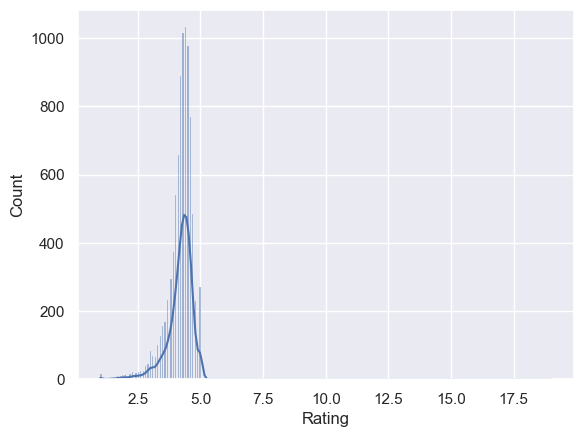

In [46]:
## for classification
if model_type == 'classification':
    print(df[target].value_counts())
    sns.countplot(x=target, data=df)
    plt.title('Distribution of Target Variable')
else:
    ## for regression, distribution
    sns.histplot(data=df, x=target, kde=True)
    #skewness and kurtosis
    print("Skewness: %f" % df[target].skew())
    print("Kurtosis: %f" % df[target].kurt())

In [ ]:
## drop rows when target variable is NA, should come back later to see how to fill the NA values
df.dropna(subset=target, inplace=True)
print(df.shape)

### 1.3 Data type conversion
1. some numeric features were treated as object due to string values entered as mistake (or combo with chars)
2. numbers with low unique value count might be categorical values
3. dates are't useful for ML, either use year/month, or time since a spefic time as numeric

In [48]:
## convert dates to year, month for ML models
## dates have different formats, and one is invalid.
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='mixed', errors='coerce')
#df['Last Updated'] = df['Last Updated'].apply(parse_date_with_na)

## year is meaningful, but month, may days till a designed date
anchor_date = pd.to_datetime('2024-01-01')
df['Days Updated'] = (anchor_date - df['Last Updated']).dt.days
df['Updated_Year'] = df['Last Updated'].dt.year
df.drop('Last Updated', axis=1, inplace=True)

In [50]:
## remove certain chars in numeric values
chars_to_replace = {'\+':'', ',':'', '\$':'', 'M': 'e+6', 'K': 'e+3'}
cols_to_clean = ['Installs','Price','Size']

## clean and conver to numeric values
for col in cols_to_clean:
    df[col]=df[col].replace(chars_to_replace, regex=True)
    df[col]=pd.to_numeric(df[col], errors="coerce")
        
df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver,till_now,Updated_Year
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000.0,Free,0.0,Everyone,Art & Design,4.0.3 and up,2185.0,2018.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up,2177.0,2018.0


In [351]:
#get_table_summary(df)

In [54]:
# 3 groups of variables, may not have discrete type.
num_cols = df.select_dtypes(include=['float64', 'int']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
dis_cols = []

# make a list of discrete variables if needed
if discretize_flag == True:
    dis_cols = [var for var in num_cols if len(df[var].unique()) <= 12]
    df[discrete]= df[discrete].astype('O')
    # update numeric cols list
    num_cols = [var for var in num_cols if var not in dis_cols]

print(num_cols, cat_cols, dis_cols)

['Rating', 'Size', 'Installs', 'Price', 'till_now', 'Updated_Year'] ['App', 'Category', 'Reviews', 'Type', 'Content Rating', 'Genres', 'Android Ver'] []


### 1.4 Missing values
1. drop features with > 60% missing values (may bring some back in 2nd round)
2. replace numeric with median, and categrorical with "unknown" (unless very few)

In [343]:
summary_df

,Column,Type,Mean,Median,STD,Unique Values,Missing Values,Missing Percent
0,App,object,N/A,N/A,N/A,8197,0,0.0
1,Category,object,N/A,N/A,N/A,34,0,0.0
2,Rating,float64,4.189542,4.3,0.545452,40,0,0.0
3,Reviews,object,N/A,N/A,N/A,5993,0,0.0
4,Size,float64,23544670.898438,15000000.0,23460115.060489,182,1725,19.397279
5,Installs,float64,16489648.148673,500000.0,86376000.19028,19,1,0.011245
6,Type,object,N/A,N/A,N/A,3,0,0.0
7,Price,float64,0.963155,0.0,16.189341,73,1,0.011245
8,Content Rating,object,N/A,N/A,N/A,6,1,0.011245
9,Genres,object,N/A,N/A,N/A,116,0,0.0


In [56]:
print("Features with > 50% missing values:")
print(summary_df['Column'][summary_df['Missing Percent'] >= 50])

## replace missing string values by mode
#df['Type'].fillna(str(df['Type'].mode().values[0]), inplace=True)

## replace missing numeric values by median
#df.fillna(df.median())

Features with > 50% missing values:
Series([], Name: Column, dtype: object)


In [67]:
#print(df[target].value_counts())

### 1.5 More detail / visualization on certain variables

In [ ]:
from wordcloud import WordCloud, STOPWORDS

plt.subplots(figsize=(10,10))
wordcloud = WordCloud(
                          background_color='black',
                          width=1920,
                          height=1080
                         ).generate(" ".join(df['Category']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
## correlation among numeric values
corr = df[num_cols].corr().round(2)
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr')

In [ ]:
## chi-square test among categorical values
sns.countplot(x = 'diag_1', palette = 'Set2', data = df)

In [ ]:
var = 'n_procedures'
sns.countplot(x = var, hue = target, palette = 'Set2', data = df)

In [ ]:
# Create a sample dataset
data = np.random.rand(100, 2)

# Select diverse samples
selected_indices = maximin_dpp(data, k=10)
diverse_samples = data[selected_indices]
print(diverse_samples)

In [ ]:
## prefer not to do LabelEncoder to keep the original string for XAI
le_dict = dict()

print(X.shape)
for col in cat_cols:
    le = LabelEncoder()
    
    X[col] = le.fit_transform(X_train[col]) # Fitting and tranforming the Train data
    X[col] = X_train[col].astype('category') # Converting the label encoded features from numerical back to categorical dtype in pandas
    le_dict[col] = le # Saving the label encoder for individual features

print(X.shape)

## 2. Pre-processing for modeling

### 2.1 pipeline to clean data

In [ ]:
# Set up the imputer
median_imputer = MeanMedianImputer(imputation_method='median')
median_imputer.fit(df)
 
# transform the data
df = median_imputer.transform(df)
print(df.shape)

In [ ]:
tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)

# With fit() the transformer finds the correlated variables and with transform() it drops them from the dataset:
Xt = tr.fit_transform(X)
# The correlated feature groups are stored in the transformer’s attributes:
tr.correlated_feature_sets_

In [62]:
from feature_engine import encoding as ce
from feature_engine import discretisation as dsc
from feature_engine import imputation as mdi
from feature_engine.pipeline import Pipeline

In [381]:
cat_cols

['App',
 'Category',
 'Reviews',
 'Type',
 'Content Rating',
 'Genres',
 'Android Ver']

In [379]:
df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver,till_now,Updated_Year
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000.0,Free,0.0,Everyone,Art & Design,4.0.3 and up,2185.0,2018.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up,2177.0,2018.0


In [134]:
# set up the pipeline
data_engineer_pipe = Pipeline([
    # add a binary missing indicator
    #('continuous_var_imputer', mdi.AddMissingIndicator(variables = [''])),
 
    # replace NA by the median
    ('continuous_var_median_imputer', mdi.MeanMedianImputer(imputation_method='median')),
 
    # replace NA by "Missing" with fill_value="Missing". If missing values are few, use mode
    ('categorical_imputer', mdi.CategoricalImputer(variables = cat_cols, imputation_method="frequent")),
    #('categorical_imputer', mdi.CategoricalImputer(variables = cat_cols, fill_value="Missing")),
    
    # disretise continuous variables using trees
    #('numerical_tree_discretiser', dsc.DecisionTreeDiscretiser(cv = 3, scoring='neg_mean_squared_error', variables = num_cols, regression=True)),
 
    # remove rare labels in categorical and discrete variables.
    ('rare_label_encoder', ce.RareLabelEncoder(
        tol = 0.03,
        n_categories=4,  ## if no more than n categories, will keep all
        replace_with='Other',
        variables = cat_cols + dis_cols)),
 
    # encode categorical and discrete variables using the target mean, need target variable
    #('categorical_encoder', ce.CountFrequencyEncoder(variables = cat_cols + dis_cols)),
    
    # scale features
    #('scaler', MinMaxScaler()),
 
    # Lasso
    #('lasso', Lasso(random_state=2909, alpha=0.005))
])
 
# train feature engineering transformers and Lasso
data_engineer_pipe.fit(df)
clean_df = data_engineer_pipe.transform(df)

print(df.shape)
print(clean_df.shape)
clean_df.head(2)

(10358, 13)
(10358, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver,till_now,Updated_Year
0,Other,Other,4.1,Other,19000000.0,10000.0,Free,0.0,Everyone,Other,4.0.3 and up,2185.0,2018.0
1,Other,Other,3.9,Other,14000000.0,500000.0,Free,0.0,Everyone,Other,4.0.3 and up,2177.0,2018.0


In [136]:
get_table_summary(clean_df)

,Column,Type,Mean,Median,STD,Unique Values,Missing Values,Missing Percent
0,App,object,N/A,N/A,N/A,1,0,0.0
1,Category,object,N/A,N/A,N/A,13,0,0.0
2,Rating,float64,4.205165,4.3,0.506868,40,0,0.0
3,Reviews,object,N/A,N/A,N/A,2,0,0.0
4,Size,float64,20624164.993242,14000000.0,20712056.269562,182,0,0.0
5,Installs,float64,14156402.252076,100000.0,80235798.982036,20,0,0.0
6,Type,object,N/A,N/A,N/A,4,0,0.0
7,Price,float64,1.030701,0.0,16.277843,92,0,0.0
8,Content Rating,object,N/A,N/A,N/A,5,0,0.0
9,Genres,object,N/A,N/A,N/A,14,0,0.0


In [138]:
clean_df['Type'].value_counts()

Type
Free       9591
Paid        765
Missing       1
0             1
Name: count, dtype: int64

### 2.2 class balance (use 'diversipy' lib to select most diverse data points)
2. one-hoting encoding
3. standadization

In [102]:
# sample from the larger class the same number of data points to smaller class 
# take array only
sub_df = subset.psa_select(clean_df.to_numpy(), 1000)
sub_df = pd.DataFrame(sub_df, columns = df.columns)
print(sub_df.shape)
sub_df.head()

(1000, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver,till_now,Updated_Year
0,10358.0,1121.0,3.9,9765.0,43000000.0,50000.0,9592.0,0.0,8383.0,4631.0,2382.0,1975.0,2018.0
1,10358.0,1943.0,4.1,9765.0,23000000.0,50000.0,9592.0,0.0,377.0,4631.0,1497.0,2849.0,2016.0
2,10358.0,388.0,4.6,9765.0,11000000.0,50000.0,9592.0,0.0,1146.0,388.0,2382.0,2103.0,2018.0
3,10358.0,408.0,4.7,9765.0,20000000.0,50000.0,9592.0,0.0,1146.0,408.0,1497.0,1982.0,2018.0
4,10358.0,3049.0,4.7,9765.0,4600000.0,50000.0,9592.0,0.0,8383.0,4631.0,1451.0,2338.0,2017.0


### 2.3 final check

## 3. Classification Model

In [ ]:
rand_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_state)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(2)

### 3.1 Train model

In [ ]:
# scaler barely affects the results and it makes the interpretation via SHAP much harder, so removed
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
])

## why not impute missing value, SimpleImputer doesn't work with get_feature_names_out()? remove this still got the same error
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[('num_tr', num_transformer, num_cols), 
                                               ('cat_tr', cat_transformer, cat_cols)])

In [ ]:
%%time

ml_model = RandomForestClassifier(random_state=rand_state)

model_name = 'Random Forest'
pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', ml_model)])
grid = [
    # 'Random Forest'
    {
        'clf__max_depth': [9],
        'clf__n_estimators': [500],
        #'clf__min_samples_leaf': [20, 30],
    },
]

# Define cross-validation objects for the inner and outer loops of the nested cross-validation
cv_inner = StratifiedKFold(n_splits=3)
cv_outer = StratifiedKFold(n_splits=5)

search = GridSearchCV(pipe, grid, scoring='roc_auc', cv=cv_inner, return_train_score=True)
scores = cross_validate(search, X, y, scoring='roc_auc', cv=cv_outer, return_train_score=True, return_estimator=True)

print('-------------------------------------------------------------')
print('Model: {}'.format(model_name))
print('Mean training AUC {}, std. dev. {}'.format(round(scores['train_score'].mean(), 3), round(scores['train_score'].std(), 3)))
print('Mean test AUC {}, std. dev. {}'.format(round(scores['test_score'].mean(), 3), round(scores['test_score'].std(), 3)))

In [ ]:
#final_model = scores['estimator'][0]
#final_model.best_estimator_.steps[1][1]

## best model only available after fit
search.fit(X, y)
print(search.best_params_)
best_model = search.best_estimator_
print(best_model)

In [ ]:
# Fit the GridSearchCV object to the training data
search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", search.best_params_)

# Get the best model
best_model = search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate ROC, it didn't work for string value?
#roc_score = roc_auc_score(y_test, y_pred)
#print("Roc score:", roc_score)

In [ ]:
cm = confusion_matrix(y_test, y_pred);
f = sns.heatmap(cm, annot=True, fmt='d')

### 3.2 Feature Inportance
#### check top 3 most important features for potential data leakage

In [ ]:
%%time
# Feature permutation importance
feat_perm_imp = permutation_importance(best_model, X, y, n_repeats=5, random_state=rand_state, n_jobs=1)

sorted_importances_idx = feat_perm_imp.importances_mean.argsort()
importances = pd.DataFrame(
    feat_perm_imp.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

fig, ax = plt.subplots(figsize=(8,6))
plt.grid()

## show pre-treatment related features are important
ax.boxplot(importances, vert=False, labels=importances.columns);
## or just plot the top 10 features
#ax.boxplot(importances.iloc[:, -10:], vert=False, labels=importances.columns[-10:]);
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel("Decrease in performance score")
ax.figure.tight_layout()

### 3.3 Explainable AI

In [229]:
# fit the preprocessor and transform the data
print(X_train.shape)
X_train_encoded = final_model.best_estimator_['preproc'].fit_transform(X_train)
print(X_train_encoded.shape)
#display(X_train_encoded[0:1])

# apply preprocessor to the test data
X_test_encoded = final_model.best_estimator_['preproc'].transform(X_test)
print(X_test_encoded.shape)

(18750, 16)
(18750, 7)
(6250, 7)


### 3.4 Model improvement:


```
if model accuracy > 80%: 
    check for data leakage  
    model tuning / Ensemble 
else:  
    check target variable (with cleanlab for potential labeling error)  
    feature engineering (new features) based on domain knowledge  
    clustering analysis:  
        dimensional reduction for visualization of problem spaces
        identify outlier, distance among classes  
        outlier detection / removal   
    explainableAI tools (raiwidgets):
        indentify subgroups with lower than average performance 
    adding synthetic data (with ydata-synthetic)
```

#### 3.4.1 Check target variable 
https://github.com/cleanlab/examples/blob/master/find_label_errors_iris/find_label_errors_iris.ipynb

## 4. Regression models

#bl_psa_df = pd.read_csv(fea_dir + "psa_features_CA_final_cohort.csv")
target = 'SalePrice'
print(train_df[target].value_counts())
X = train_df.drop(axis=1, columns=[target])
y = train_df[target]

rand_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_state)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(2)

In [ ]:
## Prepare training and testing data with pipelines
# Define data transformations
# num_features=[col for col in df.columns if df[col].dtype!='O']
num_cols = X.select_dtypes(include=['float64', 'int']).columns.tolist()
cat_cols = X.select_dtypes(include=['O', 'category']).columns.tolist()

# scaler barely affects the results and it makes the interpretation via SHAP much harder, so removed
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=rand_state, max_iter=10, tol=0.05)),
    #('scaler', StandardScaler())
])

## why not impute missing value, SimpleImputer doesn't work with get_feature_names_out()? remove this still got the same error
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[('num_tr', num_transformer, num_cols), 
                                               ('cat_tr', cat_transformer, cat_cols)])

In [ ]:
%%time

ml_model = RandomForestRegressor(random_state=rand_state)
model_name = 'Random Forest'
pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', ml_model)])
grid = [
    # 'Random Forest'
    {
        'clf__max_depth': [9],
        'clf__n_estimators': [500],
        #'clf__min_samples_leaf': [20, 30],
    },
]

# Define cross-validation objects for the inner and outer loops of the nested cross-validation
cv_inner = StratifiedKFold(n_splits=3)
cv_outer = StratifiedKFold(n_splits=5)

## score: neg_mean_squared_error
search = GridSearchCV(pipe, grid, scoring='r2', cv=cv_inner, return_train_score=True)
scores = cross_validate(search, X_train, y_train, scoring='r2', cv=cv_outer, return_train_score=True, return_estimator=True)

print('-------------------------------------------------------------')
print('Model: {}'.format(model_name))
print('Mean training R2 {}, std. dev. {}'.format(round(scores['train_score'].mean(), 3), round(scores['train_score'].std(), 3)))
print('Mean test R2 {}, std. dev. {}'.format(round(scores['test_score'].mean(), 3), round(scores['test_score'].std(), 3)))

In [ ]:
# Fit the GridSearchCV object to the training data
search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", search.best_params_)

# Get the best model
best_model = search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate the mean squared error
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

In [ ]:
%%time
# Feature permutation importance
feat_perm_imp = permutation_importance(best_model, X, y, n_repeats=5, random_state=rand_state, n_jobs=1)

sorted_importances_idx = feat_perm_imp.importances_mean.argsort()
importances = pd.DataFrame(
    feat_perm_imp.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

fig, ax = plt.subplots(figsize=(8,6))
plt.grid()

## show pre-treatment related features are important
ax.boxplot(importances, vert=False, labels=importances.columns);
## or just plot the top 10 features
#ax.boxplot(importances.iloc[:, -10:], vert=False, labels=importances.columns[-10:]);
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel("Decrease in performance score")
ax.figure.tight_layout()